In [1]:
PLATFORM = 'CW308_STM32F3'
board = 'stm32f3'

In [2]:
%%bash -s "$PLATFORM" 

cd /home/erc528/chipwhisperer/hardware/victims/firmware/test1

In [3]:
%run "/home/erc528/chipwhisperer/jupyter/Setup_Scripts/Setup_Generic.ipynb"

fw_path = '/home/erc528/chipwhisperer/hardware/victims/firmware/test1/simpleserial-aes-{}.hex'.format(PLATFORM)

cw.program_target(scope, prog, fw_path)

project = cw.create_project("test1.cwp", overwrite=True)


OSError: Could not find ChipWhisperer. Is it connected?

OSError: Could not find ChipWhisperer. Is it connected?

In [8]:
# Testing values  

key = bytearray(b'\x2b\x7e\x15\x16\x28\xae\xd2\xa6\xab\xf7\x15\x88\x09\xcf\x4f\x3c') 

text = bytearray(b'\x4e\xae\x5c\x85\xf7\x27\xcb\x2b\x82\xbb\xa8\xad\xf1\x5b\x14\x69') 

expected = bytearray(b'\x76\x81\x16\xce\x57\x30\x67\x93\x1b\x9b\x99\x14\x89\x69\x06\x74') 

target.set_key(key) 

target.simpleserial_write('p', text) 

response = target.simpleserial_read('r', 16) 

 
 

if expected == response: 

    print("SUCCESS: Operation has no effect.") 

else: 

    print("FAILURE: Operation has an effect.") 

SUCCESS: Operation has no effect.


In [5]:
from tqdm import tnrange
import numpy as np
import time

ktp = cw.ktp.Basic()
key, text = ktp.next()
target.set_key(key)

scope.adc.offset = 0
scope.adc.samples = 20000
ktp = cw.ktp.Basic()

In [6]:
trace_array = []
textin_array = []
N = 1000
for i in tnrange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    key, text = ktp.next() 

/tmp/ipykernel_11370/3994281020.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(N, desc='Capturing traces'):


Capturing traces:   0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
print(key)

CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')


<IPython.core.display.Javascript object>


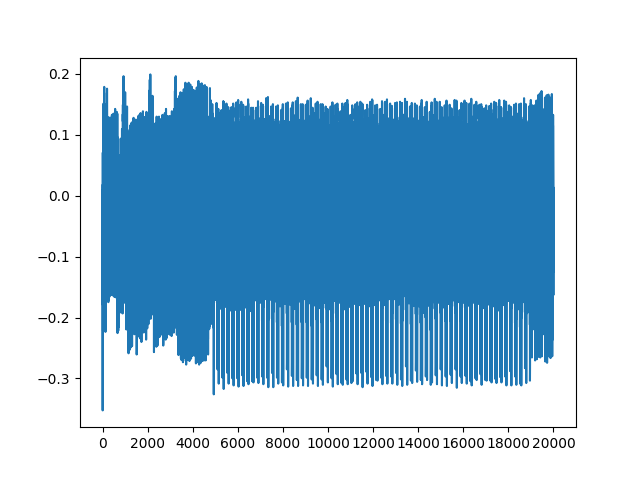

In [8]:
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib.pyplot import MultipleLocator

x_locator = MultipleLocator(2000)
ax = plt.gca()
ax.xaxis.set_major_locator(x_locator)

plt.plot(trace_array[10])

In [9]:
import os
save_dir = '/home/erc528/chipwhisperer/figures/xmega_nop'
fig_path = os.path.join(save_dir, 'nothing.png')
plt.savefig(fig_path)

In [10]:
# prepare the datas
import numpy as np
#trace_array = np.float32(trace_array)
#textin_array = np.float32(textin_array)
#print(trace_array.shape)
#print(textin_array.shape)
store_key = list(key)
store_key = np.array(store_key)
print(store_key.shape)
print(store_key)

if 'stm32f3' == board:
    attack_window = (1200, 2200)
elif 'xmega' == board:
    attack_window = (1800, 2800)
else:
    raise
print('attack_window: ', attack_window)

(16,)
[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
attack_window:  (1200, 2200)


In [11]:
# used to save the data
import os
dataDir = '/home/erc528/chipwhisperer/collected_data/XMEGA_random_NOP/XMEGA_target1/'
#dataDir = '/home/erc528/chipwhisperer/collected_data/STM32F3/STM32F3_target2++++/'
os.makedirs(dataDir, exist_ok=True)
outpath = os.path.join(dataDir, 'test_default_key.npz')
np.savez(outpath, trace_mat=trace_array, textin_mat=textin_array, key=store_key, attack_window=attack_window)
del store_key, trace_array, textin_array

In [12]:
hex_key = [hex(val) for val in key]
print(hex_key)

['0x2b', '0x7e', '0x15', '0x16', '0x28', '0xae', '0xd2', '0xa6', '0xab', '0xf7', '0x15', '0x88', '0x9', '0xcf', '0x4f', '0x3c']


In [13]:
dir_path = '/home/erc528/chipwhisperer/figures/vis_traces/stm32f3_new'
import os
os.makedirs(dir_path, exist_ok=True)

In [14]:
# disconnect the board
scope.dis()
target.dis()